In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)

Using TensorFlow backend.


In [2]:
#GLOBAL Variables
BATCH_SIZE = 128 
EPOCHS_BASE = 50 #or 100
OPT = 'adam' #optimizer for neural network 
TOL = 3e-2

In [3]:
#folder = "./Sentiment/twitter/"
folder = "./Sentiment/rotten//"

### Load Data and preprocess

In [4]:
import re
FLAGS = re.MULTILINE | re.DOTALL
def allcaps(text):
    text = text.group()
    return text.lower() + " <allcaps>"
def tokenize(text):
    # Different regex parts for smiley faces
    eyes = r"[8:=;]"
    nose = r"['`\-]?"
    def re_sub(pattern, repl):
        return re.sub(pattern, repl, text, flags=FLAGS)

    text = re_sub(r"https?:\/\/\S+\b|www\.(\w+\.)+\S*", "<url>")
    text = re_sub(r"/"," / ")
    text = re_sub(r"@\w+", "<user>")
    text = re_sub(r"{}{}[)dD]+|[)dD]+{}{}".format(eyes, nose, nose, eyes), "<smile>")
    text = re_sub(r"{}{}p+".format(eyes, nose), "<lolface>")
    text = re_sub(r"{}{}\(+|\)+{}{}".format(eyes, nose, nose, eyes), "<sadface>")
    text = re_sub(r"{}{}[\/|l*]".format(eyes, nose), "<neutralface>")
    text = re_sub(r"<3","<heart>")
    text = re_sub(r"[-+]?[.\d]*[\d]+[:,.\d]*", "<number>")
    text = re_sub(r"#\S+", "<hashtag>")
    text = re_sub(r"([!?.]){2,}", r"\1 <repeat>")
    text = re_sub(r"\b(\S*?)(.)\2{2,}\b", r"\1\2 <elong>")

    ## -- I just don't understand why the Ruby script adds <allcaps> to everything so I limited the selection.
    # text = re_sub(r"([^a-z0-9()<>'`\-]){2,}", allcaps)
    text = re_sub(r"([A-Z]){2,}", allcaps)
    return text.lower()

def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data

#texts_train = [tokenize(text) for text in read_texts(folder+"texts_train.txt")]
texts_train = read_texts(folder+"texts_train.txt")
#texts_test = [tokenize(text) for text in read_texts(folder+"texts_test.txt")]
texts_test = read_texts(folder+"texts_test.txt")

Z_train = np.loadtxt(folder+"sent_train.txt", dtype='int')
Z_test = np.loadtxt(folder+"sent_test.txt", dtype='int')

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 4999
Num. test texts:  3999


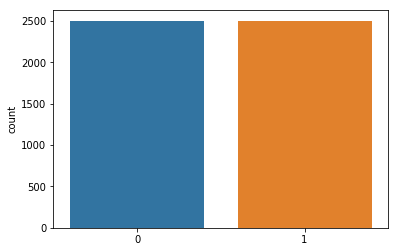

In [5]:
sns.countplot(Z_train)
plt.show()

In [5]:
from keras import preprocessing
MAX_NB_WORDS = 14000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_train+texts_test)
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)
#MAX_NB_WORDS = len(tokenizer.word_index)
print('Found %s unique tokens.' % len(tokenizer.word_index))

Found 14096 unique tokens.


(-100, 13000)

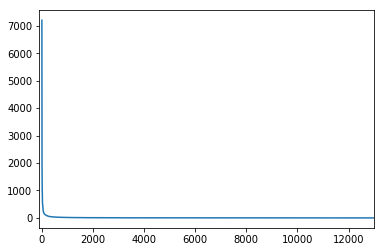

In [6]:
aux = np.asarray(list(tokenizer.word_counts.values()))
plt.plot(np.sort(aux)[::-1])
plt.xlim(-100,MAX_NB_WORDS)

In [6]:
lens = list(map(len,sequences_train))
max_L = np.max(lens)
print("Real max: ",max_L)
max_L = 50 
print("Used max: ",max_L)

X_train = preprocessing.sequence.pad_sequences(sequences_train, maxlen=max_L,dtype='int32', value=0,padding='pre')
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
print('Shape of train tensor:', X_train.shape)

Real max:  51
Used max:  50
Shape of train tensor: (4999, 50)


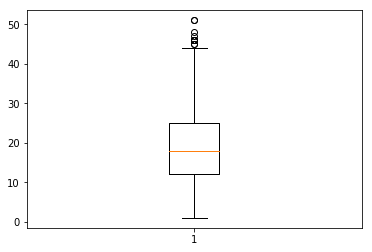

In [12]:
plt.boxplot(lens)
plt.show()

In [7]:
EMBEDDING_DIM = 300
GLOVE_FILE = "../GLOVE/glove.6B.%dd.txt"%(EMBEDDING_DIM)
#GLOVE_FILE = "../AUX_DATA/glove.twitter.27B/glove.twitter.27B.%dd.txt"%(EMBEDDING_DIM)

embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  12935


### Load annotations / Generate

In [8]:
from code.representation import *
from code.utils import *

In [9]:
print("Loading AMT data...")
y_obs = np.loadtxt(folder+"answers.txt", delimiter=' ', dtype='int16')
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N,T = y_obs.shape
Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas
print("Shape (data,annotators): ",(N,T))
print("Classes: ",Kl)

Loading AMT data...
Shape (data,annotators):  (4999, 203)
Classes:  2


In [10]:
#generate conf matrix...
confe_matrix_R = np.zeros((T,Kl,Kl),dtype=DTYPE_OP) #rodrigues add epsilon here
for t in range(T):    
    for i in range(N):
        if y_obs[i,t] != -1:
            confe_matrix_R[t,Z_train[i],y_obs[i,t]] +=1
            
    mask_nan = confe_matrix_R[t,:,:].sum(axis=-1) == 0
    mean_replace = np.mean(confe_matrix_R[t,:,:][~mask_nan],axis=0)
    for value in np.arange(Kl)[mask_nan]:
        confe_matrix_R[t,value,:] =  1 #Rodrigues 1./K -- similar  to laplace smooth (prior 1)
    confe_matrix_R[t,:,:] = confe_matrix_R[t,:,:]/confe_matrix_R[t,:,:].sum(axis=-1,keepdims=True) #normalize
confe_matrix_R

array([[[0.7058824 , 0.29411766],
        [0.33333334, 0.6666667 ]],

       [[0.94827586, 0.05172414],
        [0.13733906, 0.86266094]],

       [[0.9756098 , 0.02439024],
        [0.10526316, 0.8947368 ]],

       [[0.9306358 , 0.06936416],
        [0.07629428, 0.9237057 ]],

       [[0.94011974, 0.05988024],
        [0.22839506, 0.77160496]],

       [[0.6469111 , 0.3530889 ],
        [0.16083916, 0.83916086]],

       [[0.9344    , 0.0656    ],
        [0.07922272, 0.92077726]],

       [[0.8918919 , 0.10810811],
        [0.11267605, 0.8873239 ]],

       [[0.625     , 0.375     ],
        [0.3809524 , 0.61904764]],

       [[0.81389576, 0.18610422],
        [0.13315926, 0.8668407 ]],

       [[0.8372093 , 0.1627907 ],
        [0.22891566, 0.7710843 ]],

       [[0.89830506, 0.10169491],
        [0.06      , 0.94      ]],

       [[0.9122807 , 0.0877193 ],
        [0.14655173, 0.8534483 ]],

       [[0.9301165 , 0.06988353],
        [0.12522046, 0.8747795 ]],

       [[0.7702703 ,

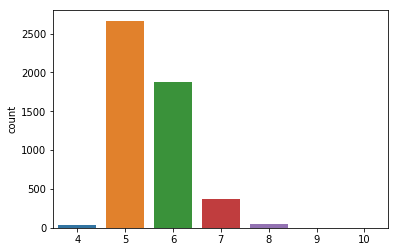

Minimum annotations in a example:  4
Maximum annotations in a example:  10
T data (expected value):  5.550310062012403
Graphics of T weights


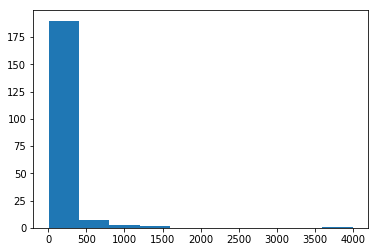

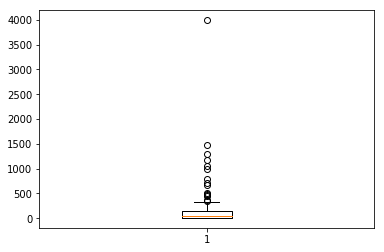

Minimum annotations by an annotator:  5
Maximum annotations by an annotator:  3993
Mean annotations by an annotator:  136.67980295566502


In [11]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

#### Delta Convergence criteria

In [11]:
from code.learning_models import LogisticRegression_Sklearn,LogisticRegression_Keras,MLP_Keras
#deep learning
from code.learning_models import default_CNN,default_RNN_text,default_CNN_text, Clonable_Model

from code.utils import EarlyStopRelative
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=TOL)

### Upper Bound Model -- ideal

In [12]:
Z_train_onehot = keras.utils.to_categorical(Z_train)
Kl = Z_train_onehot.shape[1]

model_UB = default_RNN_text(max_L, Kl, embed_M=embedding_matrix)
model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
clone_UB = Clonable_Model(model_UB)
Z_train_pred = model_UB.predict_classes(X_train)
Z_test_pred = model_UB.predict_classes(X_test)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Trained IDeal Model, Epochs to converge = 10


### Infer Labels (without predictive model)

In [18]:
from code.baseline import LabelInference

label_I = LabelInference(y_obs,TOL,type_inf = 'all')

mv_probas, mv_conf_probas = label_I.mv_labels('probas')
mv_onehot, mv_conf_onehot = label_I.mv_labels('onehot')

confe_matrix_G = get_Global_confusionM(Z_train,label_I.y_obs_repeat)

if y_obs.shape[1] <= 12000:
    ds_labels,ds_conf = label_I.DS_labels()

Representation for MV in 0.206989 sec
Representation for DS in 0.110227 sec
Estimation MV in 0.000701 sec
Iter	log-likelihood	delta-CM	delta-ER	delta-LL
1 	 -14653.167042256031
2 	 -13799.355137438279 	0.0437	0.259030	0.058268
3 	 -13743.942426302658 	0.0171	0.135132	0.004016
4 	 -13734.486476957558 	0.0083	0.096952	0.000688
5 	 -13731.737228510072 	0.0047	0.066205	0.000200
6 	 -13730.743830870631 	0.0029	0.047743	0.000072
7 	 -13730.308987607652 	0.0018	0.036592	0.000032
8 	 -13730.081076716144 	0.0012	0.028339	0.000017
Class marginals
[0.5 0.5]
Estimation for DS in 6.209649 sec


In [19]:
print("ACC MV on train:",np.mean(mv_onehot.argmax(axis=1)==Z_train))
print("ACC D&S on train:",np.mean(ds_labels.argmax(axis=1)==Z_train))

ACC MV on train: 0.8895779155831166
ACC D&S on train: 0.9151830366073215


In [20]:
model_mvsoft = clone_UB.get_model()
model_mvsoft.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvsoft.fit(X_train, mv_probas, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over soft-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvsoft.predict_classes(X_train)
Z_test_pred = model_mvsoft.predict_classes(X_test)

Trained model over soft-MV, Epochs to converge = 4


In [24]:
model_mvhard = clone_UB.get_model()
model_mvhard.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_mvhard.fit(X_train, mv_onehot, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over hard-MV, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_mvhard.predict_classes(X_train)
Z_test_pred = model_mvhard.predict_classes(X_test)

Trained model over hard-MV, Epochs to converge = 50


In [26]:
model_ds = clone_UB.get_model()
model_ds.compile(loss='categorical_crossentropy',optimizer=OPT)
hist=model_ds.fit(X_train, ds_labels, epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
print("Trained model over D&S, Epochs to converge =",len(hist.epoch))
Z_train_pred = model_ds.predict_classes(X_train)
Z_test_pred = model_ds.predict_classes(X_test)

Trained model over D&S, Epochs to converge = 4


### Raykar Model (joint predict model)

In [28]:
from code.baseline import RaykarMC
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (4999, 203, 2)


In [29]:
raykarMC = RaykarMC(max_L, y_obs_categorical.shape[-1], T,epochs=1,optimizer=OPT,DTYPE_OP=DTYPE_OP)
raykarMC.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = raykarMC.multiples_run(20,X_train,y_obs_categorical,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,
                                     tolerance=TOL)

Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 3.56 sec)	logL: -14027.826	
Iter 2/50 
M step: done,  E step: done //  (in 0.93 sec)	logL: -13323.256	Tol1: 0.05023	Tol2: 0.18033	
Iter 3/50 
M step: done,  E step: done //  (in 0.90 sec)	logL: -12498.227	Tol1: 0.06192	Tol2: 0.06820	
Iter 4/50 
M step: done,  E step: done //  (in 0.91 sec)	logL: -12287.049	Tol1: 0.01690	Tol2: 0.04648	
Iter 5/50 
M step: done,  E step: done //  (in 0.90 sec)	logL: -12118.158	Tol1: 0.01375	Tol2: 0.01207	
Finished training
Initializing new EM...
Betas shape:  (203, 2, 2)
Q estimate shape:  (4999, 2)
Iter 1/50 
M step: done,  E step: done //  (in 2.72 sec)	logL: -14025.617	
Iter 2/50 
M step: done,  E step: done //  (in 0.96 sec)	logL: -12914.514	Tol1: 0.07922	Tol2: 0.18037	
Iter 3/50 
M step: done,  E step: done //  (in 0.89 sec)	logL: -12428.179	Tol1: 0.03766	Tol2: 0.04617	
Iter 4/50 
M step: done,  E step: done //  (in 0.87 sec)	l

In [30]:
Z_train_p = raykarMC.get_predictions(X_train)
Z_train_pred =Z_train_p.argmax(axis=-1)
Z_test_p = raykarMC.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

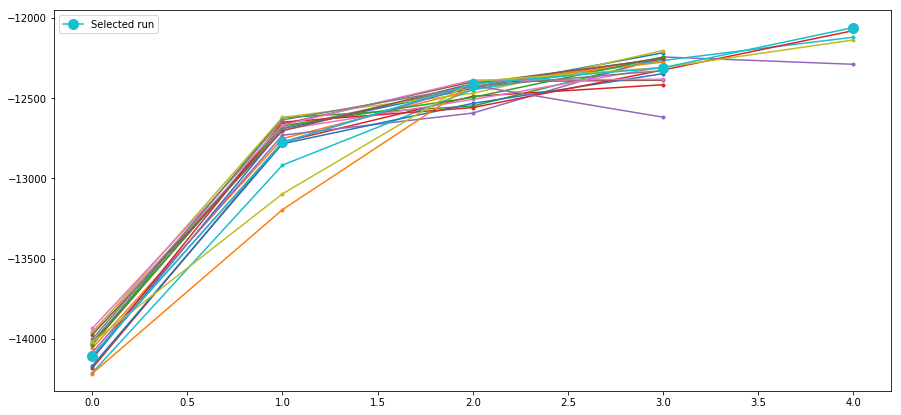

In [26]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Our Proposed

In [14]:
from code.MixtureofGroups import GroupMixtureGlo, GroupMixtureInd

In [15]:
""" AÑADIR A ARCHIVO GROUPS..."""
def define_uniform_groups(power, r, M):
    R_total = r.sum()
    uniform_groups = np.asarray([power*R_total/M for _ in range(M)])
    return uniform_groups

#get our representation 
r_obs = set_representation(y_obs,"repeat")
confe_matrix_G = get_Global_confusionM(Z_train,r_obs)

print("vector of repeats:\n",r_obs)
print("shape:",r_obs.shape)

vector of repeats:
 [[0 5]
 [5 0]
 [4 2]
 ...
 [2 4]
 [1 4]
 [3 2]]
shape: (4999, 2)


There is low entropy (information), maybe there is only a few groups in this dataset, the possible of different behavior is low.

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006591 mins
Lambda by group:  [1. 1. 1. 1. 1.]
Alphas:  (5,)
MV init:  (4999, 2)
Betas:  (5, 2, 2)
Q estimate:  (4999, 2, 5, 2)
Iter 1/0
M step: done,  E step: done //  (in 1.49 sec)	logL: -19351.873	
Finished training!


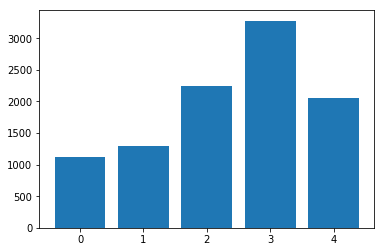

<BarContainer object of 5 artists>

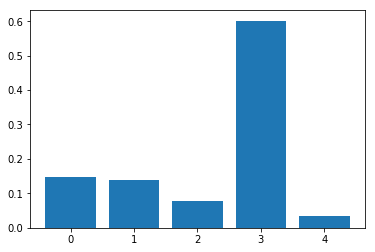

In [22]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=5,epochs=0,optimizer=OPT,dtype_op=DTYPE_OP) 

gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

logL_hists,i_r = gMixture_Global.multiples_run(1,X_train,r_obs,batch_size=BATCH_SIZE,max_iter=0,tolerance=TOL)

aux = gMixture_Global.alpha_init.sum(axis=1).sum(axis=0)
plt.bar(np.arange(gMixture_Global.M),aux)
plt.show()
gMixture_Global.get_alpha()
plt.bar(np.arange(gMixture_Global.M),gMixture_Global.get_alpha())

In [ ]:
#select M based on JS on train and accuracy on val (as train has ground truth can evaluate JS)
from code.evaluation import Evaluation_metrics
logL_Mchange = []
accTR_Mchange = []
accTE_Mchange = []
best_group_acc_Mchange = []
probas_Mchange = []
divergence1_Mchange = [] #JS Weighted
divergence2_Mchange = [] #JS
probGt_Mchange = []
inertia_Mchange = [] 

uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
uniform = True
for M_seted in range(1,10+1):
    for _ in range(10):
        gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
        gMixture_Global.define_model("default rnn text", embed=embedding_matrix)
        
        if uniform:
            #to uniform groups...
            gMixture_Global.define_priors("laplace")
            gMixture_Global.define_priors(uniform_groups) 
        
        logL_hists,i_r = gMixture_Global.multiples_run(20,Xstd_train,r_obs,batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)
        
        print("Model with %d trained"%(M_seted))
        logL_Mchange.append(logL_hists[i_r])
        probas_Mchange.append(gMixture_Global.get_alpha())

        #measure metrics..
        evaluate = Evaluation_metrics(gMixture_Global,'our1',plot=False) 
        aux = gMixture_Global.calculate_extra_components(Xstd_train,y_obs,T=T,calculate_pred_annotator=False)
        predictions_m,prob_Gt,prob_Yzt,_ =  aux #to evaluate...
        Z_train_pred = gMixture_Global.base_model.predict_classes(Xstd_train)
        results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs)

        accTR_Mchange.append(results1[0]["Accuracy"][0])
        divergence1_Mchange.append(results1[0]["Mean NormF"][0])
        divergence2_Mchange.append(results1[0]["Mean JS"][0])
        probGt_Mchange.append(prob_Gt)

        c_M = gMixture_Global.get_confusionM()
        y_o_groups = gMixture_Global.get_predictions_groups(Xstd_val).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
        Z_val_pred = gMixture_Global.base_model.predict_classes(Xstd_val)
        results2 = evaluate.calculate_metrics(Z=Z_val,Z_pred=Z_val_pred,conf_pred=c_M, y_o_groups=y_o_groups)

        best_group_acc_Mchange.append(np.max(results2[0]["Accuracy"]))
        accTE_Mchange.append(results2[1]["Accuracy"][0])
        inertia_Mchange.append(evaluate.inertia)
        
        del gMixture_Global,logL_hists,evaluate,predictions_m,prob_Gt,prob_Yzt,Z_train_pred,results1,results2,Z_val_pred
        gc.collect()
        keras.backend.clear_session()
# cada 10 obtener promedio
T_models = 9
R = 10
logL_Mchange = [np.mean( [value[-1] for value in logL_Mchange[i*R:(i+1)*R] ] ) for i in range(T_models)]
accTR_Mchange = [np.mean(accTR_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
accTE_Mchange = [np.mean(accTE_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
best_group_acc_Mchange = [np.mean(best_group_acc_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
probas_Mchange = [np.mean(probas_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
divergence1_Mchange = [np.mean(divergence1_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
divergence2_Mchange = [np.mean(divergence2_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)] #KL or JS
probGt_Mchange = [np.mean(probGt_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]
inertia_Mchange = [np.mean(inertia_Mchange[i*R:(i+1)*R],axis=0) for i in range(T_models)]

In [ ]:
plot_Mchange(logL_Mchange,
         accTR_Mchange,
         accTE_Mchange,
         best_group_acc_Mchange,
         probas_Mchange,
         divergence1_Mchange,
             divergence2_Mchange,
         probGt_Mchange,
         inertia_Mchange
            )

In [ ]:
#T if i know T
print(T)
M_values = range(1,1+len(logL_Mchange))
t = pd.DataFrame()
t["#Groups"] = M_values
t[">=1 annotator"] = [ np.sum(probas*T >= 1) for probas in probas_Mchange]
t[">=2 annotator"] = [ np.sum(probas*T >= 2) for probas in probas_Mchange] #si agrupa al menos tiene 2
t["Used on annotators"] = [ len(np.unique(prob_Gt.argmax(axis=1))) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.01"] = [ np.sum(prob_Gt.max(axis=0)>=0.01) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t["Used on annotators limit >=0.05"] = [ np.sum(prob_Gt.max(axis=0)>=0.05) for prob_Gt in probGt_Mchange ]#based on p(g|t)
t

In [16]:
M_seted = 3 #??

uniform = False
if uniform:
    uniform_groups = define_uniform_groups(0.1, r_obs, M_seted)
    print(uniform_groups)

In [17]:
gMixture_Global = GroupMixtureGlo(max_L,Kl=r_obs.shape[1],M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Global.define_model("default rnn text", embed=embedding_matrix)

if uniform:
    gMixture_Global.define_priors("laplace")
    gMixture_Global.define_priors(uniform_groups)

logL_hists,i_r = gMixture_Global.multiples_run(20,X_train,r_obs,
                                               batch_size=BATCH_SIZE,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.005796 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 3.29 sec)	logL: -17323.316	
Iter 2/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -16731.100	Tol1: 0.03419	Tol2: 0.39255	Tol3: 0.03444	
Iter 3/50
M step: done,  E step: done //  (in 1.08 sec)	logL: -16148.939	Tol1: 0.03480	Tol2: 0.21176	Tol3: 0.04178	
Iter 4/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -16005.504	Tol1: 0.00888	Tol2: 0.16050	Tol3: 0.04489	
Iter 5/50
M step: done,  E step: done //  (in 1.13 sec)	logL: -15293.144	Tol1: 0.04451	Tol2: 0.16353	Tol3: 0.08576	
Iter 6/50
M step: done,  E step: done //  (in 1.13 sec)	logL: -14917.002	Tol1: 0.02460	Tol2: 0.11053	Tol3: 0.05269	
Iter 7/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -14608.757	Tol1: 0.02066	Tol2: 0.08982	Tol3: 0.04132	
Iter 8/50
M step: done,  E step: done /

M step: done,  E step: done //  (in 1.09 sec)	logL: -11483.693	Tol1: 0.00655	Tol2: 0.04236	Tol3: 0.02105	
Iter 25/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -11429.933	Tol1: 0.00468	Tol2: 0.04764	Tol3: 0.02468	
Iter 26/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -11373.531	Tol1: 0.00493	Tol2: 0.04760	Tol3: 0.02381	
Iter 27/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -11305.350	Tol1: 0.00599	Tol2: 0.04718	Tol3: 0.02038	
Iter 28/50
M step: done,  E step: done //  (in 1.08 sec)	logL: -11196.900	Tol1: 0.00959	Tol2: 0.03056	Tol3: 0.01688	
Iter 29/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -11196.643	Tol1: 0.00002	Tol2: 0.02933	Tol3: 0.01437	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006110 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (4999, 2, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 2.88 sec)	logL: -17308.233	
Iter 2/50
M step: done,  

M step: done,  E step: done //  (in 1.12 sec)	logL: -14290.584	Tol1: 0.02493	Tol2: 0.08992	Tol3: 0.03284	
Iter 8/50
M step: done,  E step: done //  (in 1.07 sec)	logL: -14017.233	Tol1: 0.01913	Tol2: 0.08082	Tol3: 0.03216	
Iter 9/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -13701.517	Tol1: 0.02252	Tol2: 0.06897	Tol3: 0.02365	
Iter 10/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -13756.637	Tol1: 0.00402	Tol2: 0.06752	Tol3: 0.03011	
Iter 11/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -13242.062	Tol1: 0.03741	Tol2: 0.14251	Tol3: 0.08580	
Iter 12/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -13208.061	Tol1: 0.00257	Tol2: 0.08467	Tol3: 0.04682	
Iter 13/50
M step: done,  E step: done //  (in 1.13 sec)	logL: -12885.532	Tol1: 0.02442	Tol2: 0.14376	Tol3: 0.08786	
Iter 14/50
M step: done,  E step: done //  (in 1.13 sec)	logL: -12413.989	Tol1: 0.03659	Tol2: 0.10461	Tol3: 0.06292	
Iter 15/50
M step: done,  E step: done //  (in 1.14 sec)	logL: -12788.297	Tol

M step: done,  E step: done //  (in 1.11 sec)	logL: -13989.051	Tol1: 0.04547	Tol2: 0.13720	Tol3: 0.08044	
Iter 10/50
M step: done,  E step: done //  (in 1.08 sec)	logL: -14048.282	Tol1: 0.00423	Tol2: 0.07430	Tol3: 0.03618	
Iter 11/50
M step: done,  E step: done //  (in 1.08 sec)	logL: -13657.065	Tol1: 0.02785	Tol2: 0.18344	Tol3: 0.10762	
Iter 12/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -13121.494	Tol1: 0.03922	Tol2: 0.14346	Tol3: 0.08734	
Iter 13/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -12617.664	Tol1: 0.03840	Tol2: 0.10787	Tol3: 0.06014	
Iter 14/50
M step: done,  E step: done //  (in 1.12 sec)	logL: -12510.895	Tol1: 0.00846	Tol2: 0.05986	Tol3: 0.03434	
Iter 15/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -12231.436	Tol1: 0.02234	Tol2: 0.09683	Tol3: 0.05929	
Iter 16/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -11999.245	Tol1: 0.01898	Tol2: 0.04253	Tol3: 0.01806	
Iter 17/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -11930.855	T

M step: done,  E step: done //  (in 1.07 sec)	logL: -11390.896	Tol1: 0.01745	Tol2: 0.09925	Tol3: 0.05795	
Iter 25/50
M step: done,  E step: done //  (in 1.08 sec)	logL: -11328.509	Tol1: 0.00548	Tol2: 0.04544	Tol3: 0.02751	
Iter 26/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -11803.341	Tol1: 0.04191	Tol2: 0.03664	Tol3: 0.02260	
Iter 27/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -11300.960	Tol1: 0.04256	Tol2: 0.22222	Tol3: 0.13298	
Iter 28/50
M step: done,  E step: done //  (in 1.09 sec)	logL: -11101.063	Tol1: 0.01769	Tol2: 0.11710	Tol3: 0.06707	
Iter 29/50
M step: done,  E step: done //  (in 1.12 sec)	logL: -11064.767	Tol1: 0.00327	Tol2: 0.04045	Tol3: 0.02461	
Iter 30/50
M step: done,  E step: done //  (in 1.11 sec)	logL: -11036.034	Tol1: 0.00260	Tol2: 0.02504	Tol3: 0.01320	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.006209 mins
Lambda by group:  [1. 1. 1.]
Alphas:  (3,)
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:

M step: done,  E step: done //  (in 1.08 sec)	logL: -13125.448	Tol1: 0.02646	Tol2: 0.08167	Tol3: 0.04269	
Iter 13/50
M step: done,  E step: done //  (in 1.15 sec)	logL: -12963.488	Tol1: 0.01234	Tol2: 0.05459	Tol3: 0.02769	
Iter 14/50
M step: done,  E step: done //  (in 1.12 sec)	logL: -12953.298	Tol1: 0.00079	Tol2: 0.06054	Tol3: 0.03694	
Iter 15/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -12859.629	Tol1: 0.00723	Tol2: 0.13327	Tol3: 0.07941	
Iter 16/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -12335.900	Tol1: 0.04073	Tol2: 0.10565	Tol3: 0.06527	
Iter 17/50
M step: done,  E step: done //  (in 1.10 sec)	logL: -12201.733	Tol1: 0.01088	Tol2: 0.08512	Tol3: 0.04421	
Iter 18/50
M step: done,  E step: done //  (in 1.12 sec)	logL: -11927.307	Tol1: 0.02249	Tol2: 0.06615	Tol3: 0.03449	
Iter 19/50
M step: done,  E step: done //  (in 1.08 sec)	logL: -11863.989	Tol1: 0.00531	Tol2: 0.06126	Tol3: 0.03686	
Iter 20/50
M step: done,  E step: done //  (in 1.12 sec)	logL: -11936.020	T

In [19]:
Z_train_p = gMixture_Global.get_predictions(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Global.get_predictions(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)

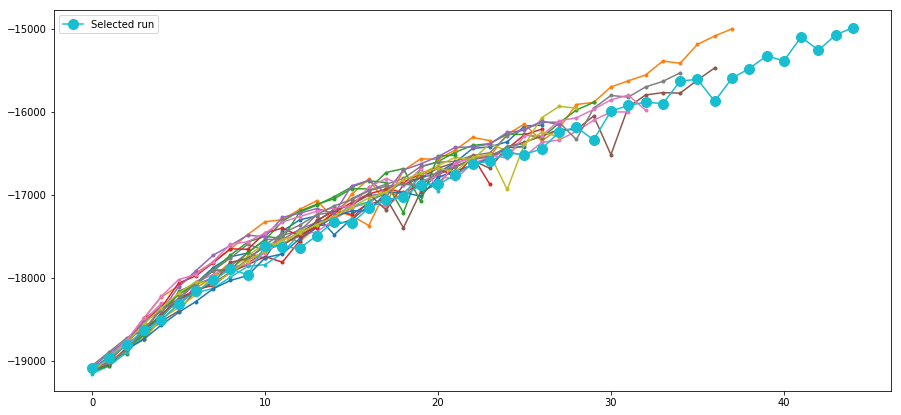

In [27]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

In [18]:
Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
T_idx_unique = np.arange(T).reshape(-1,1)

A = keras.utils.to_categorical(np.arange(T), num_classes=T) #fast way
print("shape of annotator representation (T, R_t)=", A.shape)

shape of annotator representation (T, R_t)= (203, 203)


shape of annotator representation (T, R_t)= (203, 2)


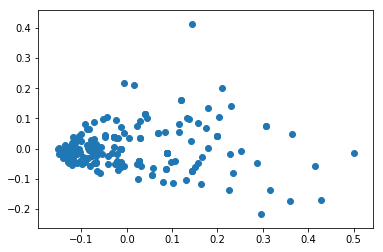

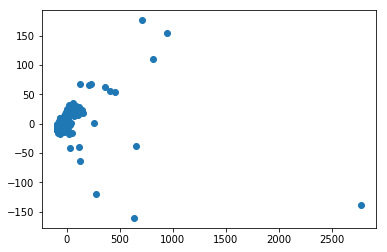

array([[1.800e+01, 1.700e+01],
       [2.520e+02, 2.130e+02],
       [4.600e+01, 5.200e+01],
       [3.500e+02, 3.630e+02],
       [1.940e+02, 1.350e+02],
       [1.610e+03, 2.383e+03],
       [6.370e+02, 6.570e+02],
       [1.480e+02, 1.420e+02],
       [2.300e+01, 2.200e+01],
       [3.790e+02, 4.070e+02],
       [9.100e+01, 7.800e+01],
       [5.600e+01, 5.300e+01],
       [1.210e+02, 1.090e+02],
       [6.300e+02, 5.380e+02],
       [6.700e+01, 7.700e+01],
       [3.320e+02, 3.280e+02],
       [1.400e+01, 1.100e+01],
       [8.000e+01, 6.000e+01],
       [1.000e+01, 1.900e+01],
       [5.600e+01, 7.900e+01],
       [6.400e+01, 9.100e+01],
       [1.270e+02, 9.800e+01],
       [1.050e+02, 1.000e+02],
       [5.000e+00, 1.000e+01],
       [5.200e+01, 6.300e+01],
       [4.800e+01, 6.200e+01],
       [8.000e+01, 6.500e+01],
       [2.170e+02, 2.760e+02],
       [1.200e+01, 1.300e+01],
       [1.100e+01, 1.900e+01],
       [2.600e+01, 3.400e+01],
       [8.900e+01, 1.060e+02],
       [

In [19]:
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, r_obs.argmax(axis=-1))

#A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten
A_rep = np.zeros((conf_mat.shape[0], Kl))
for t in range(A_rep.shape[0]):
    A_rep[t] = JS_confmatrixs(conf_mat_norm[t], np.identity(Kl),raw=True) #distancia a I (MV)
    
print("shape of annotator representation (T, R_t)=", A_rep.shape)

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


A_rep = np.zeros((y_obs.shape[1], Kl))
for i in range(N):
    for l, t_idx in enumerate(T_idx[i]):
        obs_t = Y_ann_train[i][l].argmax(axis=-1)
        A_rep[t_idx, obs_t] += 1
    
from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()
A_rep

In [20]:
#different M_seted??
M_seted = 3

In [21]:
gMixture_Ind1 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind1.define_model("default rnn text", embed=embedding_matrix)

#gMixture_Ind.define_model_group("mlp", T, M_seted, 1, BatchN=True, embed=True, embed_M=A) #con o sin BN
gMixture_Ind1.define_model_group("perceptron", T, embed=True, embed_M=A, BatchN=True,bias=False)

logL_hists,i_r = gMixture_Ind1.multiples_run(20,X_train,Y_ann_train, T_idx, A=[], batch_size=BATCH_SIZE,
                                    pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL)

Initializing new EM...
A = Son ortonormales / No fueron entregados!
Doing clustering...Done!
Get init alphas in 0.002512 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.81 sec)	logL: -17011.753	
Iter 2/50
M step: done,  E step: done //  (in 1.51 sec)	logL: -15871.510	Tol1: 0.06703	Tol2: 0.16927	
Iter 3/50
M step: done,  E step: done //  (in 1.54 sec)	logL: -15039.787	Tol1: 0.05240	Tol2: 0.15491	
Iter 4/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -14582.792	Tol1: 0.03039	Tol2: 0.12195	
Iter 5/50
M step: done,  E step: done //  (in 1.56 sec)	logL: -14146.074	Tol1: 0.02995	Tol2: 0.09788	
Iter 6/50
M step: done,  E step: done //  (in 1.35 sec)	logL: -13736.010	Tol1: 0.02899	Tol2: 0.06742	
Iter 7/50
M step: done,  E step: done //  (in 1.44 sec)	logL: -13319.128	Tol1: 0.03035	Tol2: 0.07219	
Iter 8/50
M step: done,  E step: done //  (in

M step: done,  E step: done //  (in 1.50 sec)	logL: -11242.379	Tol1: 0.00494	Tol2: 0.09579	
Iter 19/50
M step: done,  E step: done //  (in 1.51 sec)	logL: -10951.021	Tol1: 0.02592	Tol2: 0.06960	
Iter 20/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10737.777	Tol1: 0.01947	Tol2: 0.06323	
Iter 21/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10635.629	Tol1: 0.00951	Tol2: 0.06585	
Iter 22/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10582.252	Tol1: 0.00502	Tol2: 0.06815	
Iter 23/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10534.671	Tol1: 0.00450	Tol2: 0.04765	
Iter 24/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10448.240	Tol1: 0.00820	Tol2: 0.03023	
Iter 25/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10884.681	Tol1: 0.04177	Tol2: 0.02929	
Iter 26/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10525.303	Tol1: 0.03302	Tol2: 0.09281	
Iter 27/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10604.227	Tol1: 0.00

M step: done,  E step: done //  (in 1.48 sec)	logL: -11317.817	Tol1: 0.02480	Tol2: 0.11838	
Iter 21/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -11122.167	Tol1: 0.01729	Tol2: 0.14908	
Iter 22/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -11045.727	Tol1: 0.00687	Tol2: 0.06217	
Iter 23/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10926.884	Tol1: 0.01076	Tol2: 0.09954	
Iter 24/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10736.211	Tol1: 0.01745	Tol2: 0.08274	
Iter 25/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -10723.990	Tol1: 0.00114	Tol2: 0.07471	
Iter 26/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10564.089	Tol1: 0.01491	Tol2: 0.07534	
Iter 27/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -10411.779	Tol1: 0.01442	Tol2: 0.06934	
Iter 28/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -10444.437	Tol1: 0.00314	Tol2: 0.07040	
Iter 29/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10330.895	Tol1: 0.01

M step: done,  E step: done //  (in 1.37 sec)	logL: -14590.548	Tol1: 0.01523	Tol2: 0.09613	
Iter 6/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -14137.479	Tol1: 0.03105	Tol2: 0.10060	
Iter 7/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -14230.429	Tol1: 0.00657	Tol2: 0.06836	
Iter 8/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -13549.092	Tol1: 0.04788	Tol2: 0.10472	
Iter 9/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -13002.005	Tol1: 0.04038	Tol2: 0.06823	
Iter 10/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -12664.148	Tol1: 0.02598	Tol2: 0.11127	
Iter 11/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -12578.211	Tol1: 0.00679	Tol2: 0.06199	
Iter 12/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -12089.801	Tol1: 0.03883	Tol2: 0.07033	
Iter 13/50
M step: done,  E step: done //  (in 1.51 sec)	logL: -11870.870	Tol1: 0.01811	Tol2: 0.07345	
Iter 14/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -11841.851	Tol1: 0.00244	

M step: done,  E step: done //  (in 1.52 sec)	logL: -12149.658	Tol1: 0.01177	Tol2: 0.06424	
Iter 12/50
M step: done,  E step: done //  (in 1.54 sec)	logL: -11938.676	Tol1: 0.01737	Tol2: 0.11584	
Iter 13/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -11603.444	Tol1: 0.02808	Tol2: 0.07443	
Iter 14/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -11802.961	Tol1: 0.01719	Tol2: 0.06425	
Iter 15/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -11322.387	Tol1: 0.04072	Tol2: 0.12594	
Iter 16/50
M step: done,  E step: done //  (in 1.51 sec)	logL: -11154.383	Tol1: 0.01484	Tol2: 0.10253	
Iter 17/50
M step: done,  E step: done //  (in 1.53 sec)	logL: -10987.392	Tol1: 0.01497	Tol2: 0.06013	
Iter 18/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -10968.248	Tol1: 0.00174	Tol2: 0.08327	
Iter 19/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -10818.511	Tol1: 0.01365	Tol2: 0.07218	
Iter 20/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -10741.027	Tol1: 0.00

In [42]:
Z_train_p = gMixture_Ind1.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind1.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind1.get_predictions_g(T_idx_unique) 

In [52]:
gMixture_Ind3 = GroupMixtureInd(max_L,Kl=Kl,M=M_seted,epochs=1,optimizer=OPT,dtype_op=DTYPE_OP) 
gMixture_Ind3.define_model("default rnn text", embed=embedding_matrix)

gMixture_Ind3.define_model_group("mlp", A_rep.shape[1], Kl*M_seted, 1, BatchN=False, embed=False) #con BN

logL_hists,i_r = gMixture_Ind3.multiples_run(20,X_train,Y_ann_train, T_idx, A=A_rep, batch_size=BATCH_SIZE,
                                   pre_init_z=3,pre_init_g=0,max_iter=EPOCHS_BASE,tolerance=TOL) 

Needed params (units,deep,drop,BatchN?)
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000451 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.73 sec)	logL: -16385.081	
Iter 2/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -15368.286	Tol1: 0.06206	Tol2: 0.15788	
Iter 3/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -14715.362	Tol1: 0.04249	Tol2: 0.13073	
Iter 4/50
M step: done,  E step: done //  (in 1.59 sec)	logL: -14545.548	Tol1: 0.01154	Tol2: 0.09000	
Iter 5/50
M step: done,  E step: done //  (in 1.55 sec)	logL: -14203.449	Tol1: 0.02352	Tol2: 0.09890	
Iter 6/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -13714.262	Tol1: 0.03444	Tol2: 0.14518	
Iter 7/50
M step: done,  E step: done //  (in 1.52 sec)	logL: -13879.489	Tol1: 0.01205	Tol2: 0.06848	
Iter 8/50
M step: done,  E step: done //  (in 1.50

M step: done,  E step: done //  (in 1.49 sec)	logL: -13606.201	Tol1: 0.03878	Tol2: 0.08724	
Iter 8/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -13592.804	Tol1: 0.00098	Tol2: 0.04283	
Iter 9/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -13001.815	Tol1: 0.04348	Tol2: 0.13118	
Iter 10/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -12709.259	Tol1: 0.02250	Tol2: 0.02332	
Finished training!
Initializing new EM...
Doing clustering...Done!
Get init alphas in 0.000351 mins
Lambda by group:  [1. 1. 1.]
Pre-train networks over *z* on 3 epochs... Done!
MV init:  (4999, 2)
Betas:  (3, 2, 2)
Q estimate:  (27746, 3, 2)
Iter 1/50
M step: done,  E step: done //  (in 4.14 sec)	logL: -16739.125	
Iter 2/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -15375.340	Tol1: 0.08147	Tol2: 0.28507	
Iter 3/50
M step: done,  E step: done //  (in 1.50 sec)	logL: -14970.668	Tol1: 0.02632	Tol2: 0.08203	
Iter 4/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -14553.487	Tol1: 0

M step: done,  E step: done //  (in 1.47 sec)	logL: -14434.825	Tol1: 0.03689	Tol2: 0.08564	
Iter 5/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -14128.764	Tol1: 0.02120	Tol2: 0.08935	
Iter 6/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -13873.334	Tol1: 0.01808	Tol2: 0.10512	
Iter 7/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -13700.367	Tol1: 0.01247	Tol2: 0.07288	
Iter 8/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -13294.131	Tol1: 0.02965	Tol2: 0.07060	
Iter 9/50
M step: done,  E step: done //  (in 1.45 sec)	logL: -12938.015	Tol1: 0.02679	Tol2: 0.05947	
Iter 10/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -12594.163	Tol1: 0.02658	Tol2: 0.06212	
Iter 11/50
M step: done,  E step: done //  (in 1.47 sec)	logL: -12410.575	Tol1: 0.01458	Tol2: 0.06107	
Iter 12/50
M step: done,  E step: done //  (in 1.48 sec)	logL: -12501.211	Tol1: 0.00730	Tol2: 0.07237	
Iter 13/50
M step: done,  E step: done //  (in 1.49 sec)	logL: -12212.036	Tol1: 0.02313	T

In [53]:
Z_train_p = gMixture_Ind3.get_predictions_z(X_train)
Z_train_pred = Z_train_p.argmax(axis=-1)
Z_test_p = gMixture_Ind3.get_predictions_z(X_test)
Z_test_pred = Z_test_p.argmax(axis=-1)
prob_Gt = gMixture_Ind3.get_predictions_g(A_rep) 

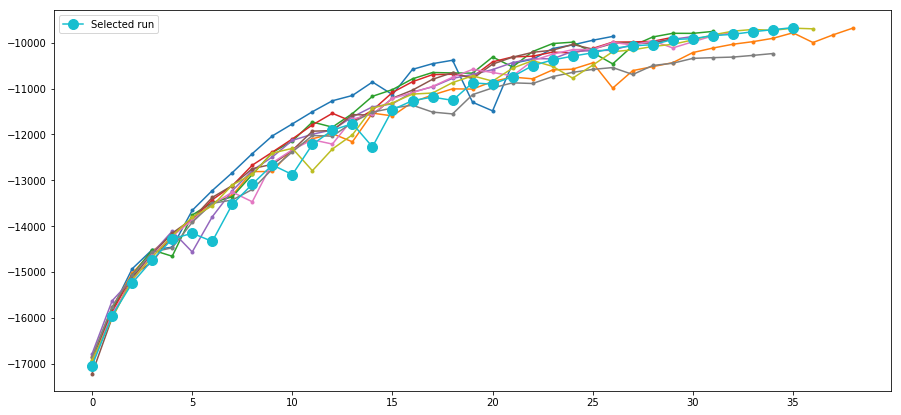

In [87]:
plt.figure(figsize=(15,7))
for a, value in enumerate(logL_hists): #logL_hists
    if a != i_r:
        plt.plot(range(len(value)),value,'.-')
plt.plot(range(len(logL_hists[i_r])),logL_hists[i_r],'o-',markersize=10,label="Selected run")
plt.legend()
plt.show()

### Compare trained models

In [23]:
#Import it:
from code.evaluation import Evaluation_metrics

In [41]:
ourCallback = EarlyStopRelative(monitor='loss',patience=1,min_delta=3e-2)

aux_tr = []
aux_te = []
for _ in range(20):
    model_UB = clone_UB.get_model()
    model_UB.compile(loss='categorical_crossentropy',optimizer=OPT)
    hist = model_UB.fit(X_train,Z_train_onehot,epochs=EPOCHS_BASE,batch_size=BATCH_SIZE,verbose=0,callbacks=[ourCallback])
    print("Trained IDeal Model, Epochs to converge =",len(hist.epoch))
    Z_train_pred = model_UB.predict_classes(X_train)
    Z_test_pred = model_UB.predict_classes(X_test)

    evaluate = Evaluation_metrics(model_UB,'keras',X_train.shape[0], plot=False)
    aux_tr += evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred)
    aux_te += evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)
    
final_tr_m = get_mean_dataframes(aux_tr)#.to_csv("Sentiment_Ideal_train.csv",index=False)
final_tr_std = get_mean_dataframes(aux_tr, mean_std=False)#.to_csv("Sentiment_Ideal_train_std.csv",index=False)
final_te_m = get_mean_dataframes(aux_te)#.to_csv("Sentiment_Ideal_test.csv",index=False)
final_te_std = get_mean_dataframes(aux_te, mean_std=False)#.to_csv("Sentiment_Ideal_test_std.csv",index=False)
final_tr_m.merge(final_tr_std.iloc[:,1:], left_index=True, right_index=True)

Trained IDeal Model, Epochs to converge = 7
Trained IDeal Model, Epochs to converge = 7
Trained IDeal Model, Epochs to converge = 4
Trained IDeal Model, Epochs to converge = 6
Trained IDeal Model, Epochs to converge = 5
Trained IDeal Model, Epochs to converge = 20
Trained IDeal Model, Epochs to converge = 3
Trained IDeal Model, Epochs to converge = 29
Trained IDeal Model, Epochs to converge = 4
Trained IDeal Model, Epochs to converge = 5
Trained IDeal Model, Epochs to converge = 38
Trained IDeal Model, Epochs to converge = 5
Trained IDeal Model, Epochs to converge = 11
Trained IDeal Model, Epochs to converge = 5
Trained IDeal Model, Epochs to converge = 4
Trained IDeal Model, Epochs to converge = 6
Trained IDeal Model, Epochs to converge = 14
Trained IDeal Model, Epochs to converge = 38
Trained IDeal Model, Epochs to converge = 24
Trained IDeal Model, Epochs to converge = 5


,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.888038,0.888038,0.887758,0.076008,0.076008,0.07621


In [42]:
final_te_m.merge(final_te_std.iloc[:,1:], left_index=True, right_index=True)

,,Accuracy_x,F1 (micro)_x,F1 (macro)_x,Accuracy_y,F1 (micro)_y,F1 (macro)_y
0,All,0.729932,0.729932,0.728896,0.007172,0.007172,0.00745


*** Soft-Majority (Train with softMV) ***
Train
Calculate confusion matrix on repeat version


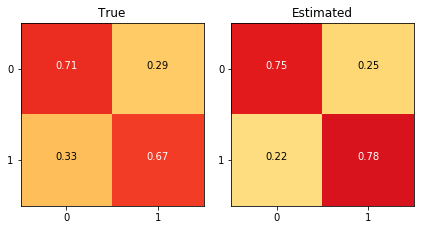

JS divergence: 0.007	Norm Frobenius: 0.086


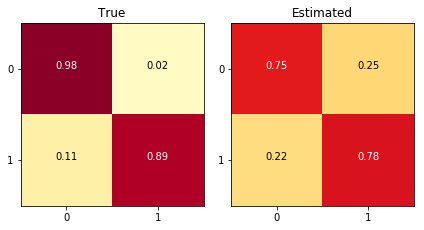

JS divergence: 0.053	Norm Frobenius: 0.180


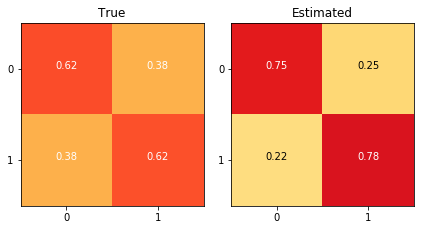

JS divergence: 0.018	Norm Frobenius: 0.144


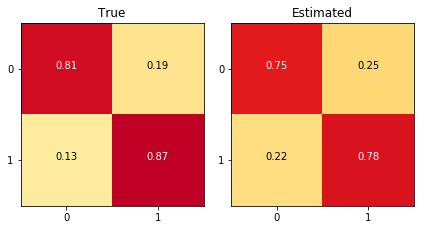

JS divergence: 0.007	Norm Frobenius: 0.077


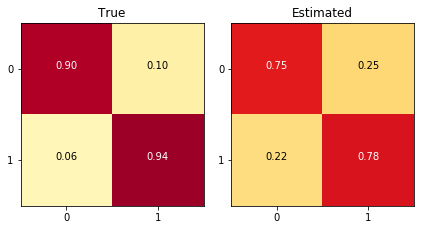

JS divergence: 0.034	Norm Frobenius: 0.155


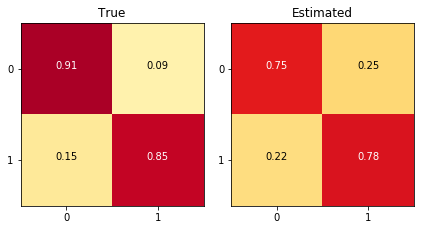

JS divergence: 0.021	Norm Frobenius: 0.127


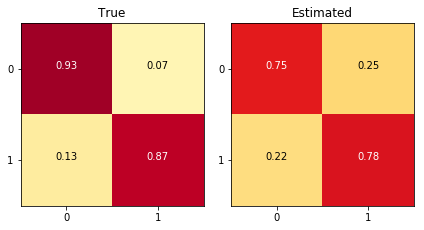

JS divergence: 0.029	Norm Frobenius: 0.145


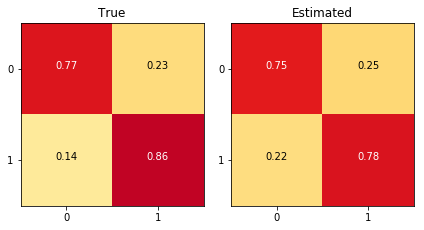

JS divergence: 0.004	Norm Frobenius: 0.056


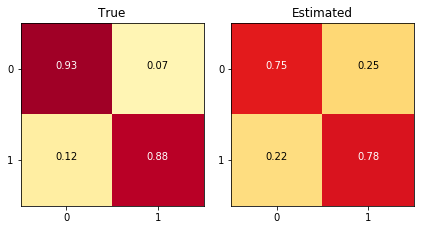

JS divergence: 0.031	Norm Frobenius: 0.149


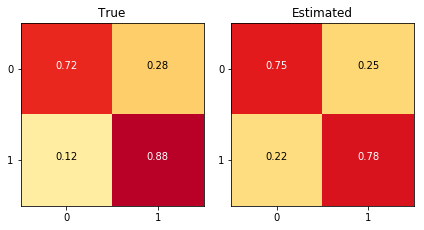

JS divergence: 0.007	Norm Frobenius: 0.075


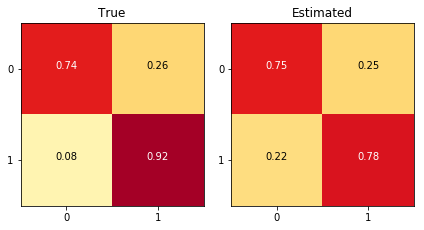

JS divergence: 0.015	Norm Frobenius: 0.100


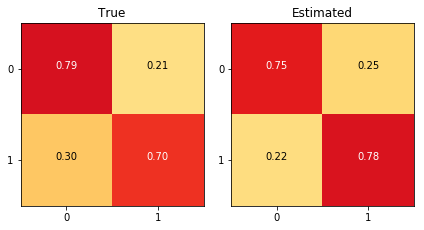

JS divergence: 0.004	Norm Frobenius: 0.068


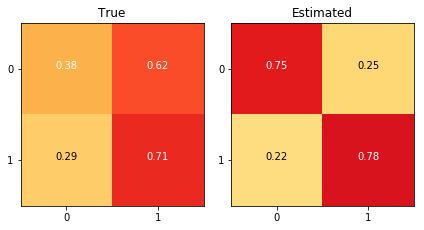

JS divergence: 0.055	Norm Frobenius: 0.268


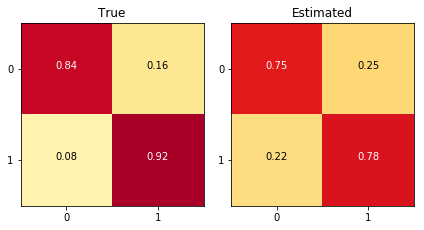

JS divergence: 0.018	Norm Frobenius: 0.115


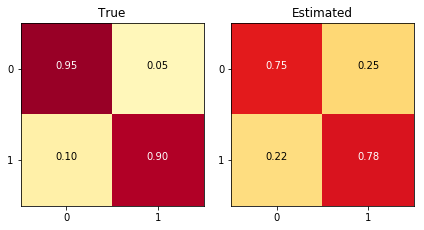

JS divergence: 0.039	Norm Frobenius: 0.163
Calculate confusion matrix on global version


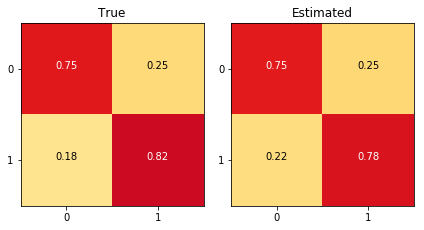

JS divergence: 0.001	Norm Frobenius: 0.031
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.783,0.783,0.7808,0.1869,0.061,0.1438,0.0282,0.031,0.0011


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7394,0.7394,0.7367


In [23]:
evaluate = Evaluation_metrics(model_mvsoft,'keras',X_train.shape[0], text=True)
evaluate.set_T_weights(T_weights)
print("*** Soft-Majority (Train with softMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_probas, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_probas)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Hard-Majority (Train with hardMV) ***
Train
Calculate confusion matrix on repeat version


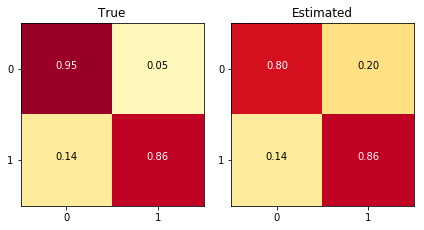

JS divergence: 0.020	Norm Frobenius: 0.107


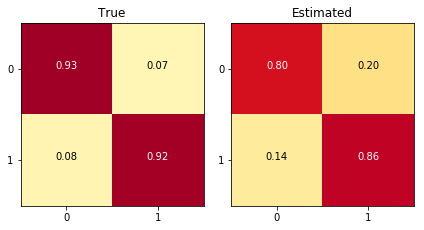

JS divergence: 0.018	Norm Frobenius: 0.104


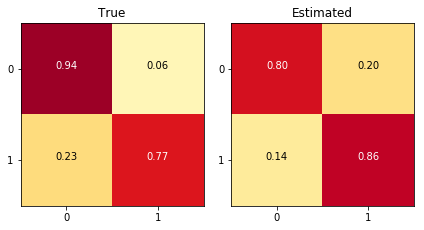

JS divergence: 0.022	Norm Frobenius: 0.120


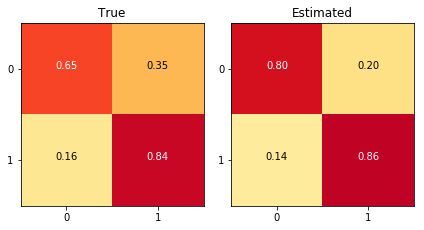

JS divergence: 0.011	Norm Frobenius: 0.107


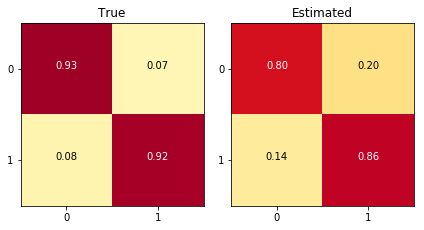

JS divergence: 0.019	Norm Frobenius: 0.106


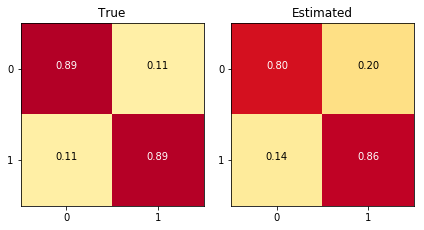

JS divergence: 0.007	Norm Frobenius: 0.070


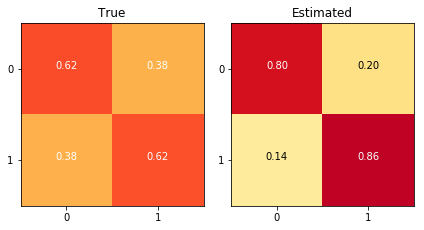

JS divergence: 0.042	Norm Frobenius: 0.210


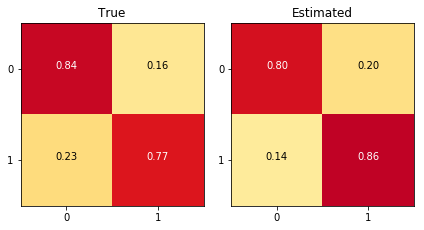

JS divergence: 0.006	Norm Frobenius: 0.071


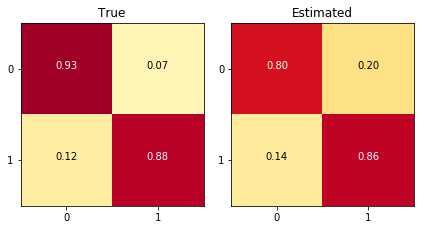

JS divergence: 0.015	Norm Frobenius: 0.097


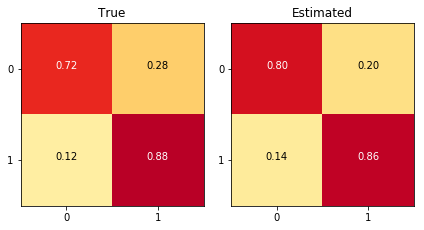

JS divergence: 0.003	Norm Frobenius: 0.058


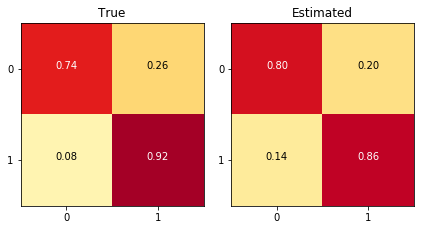

JS divergence: 0.005	Norm Frobenius: 0.057


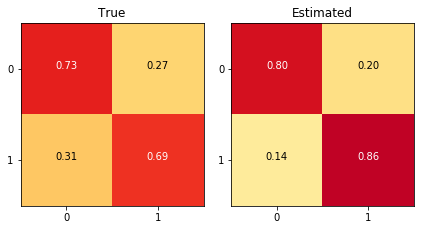

JS divergence: 0.017	Norm Frobenius: 0.128


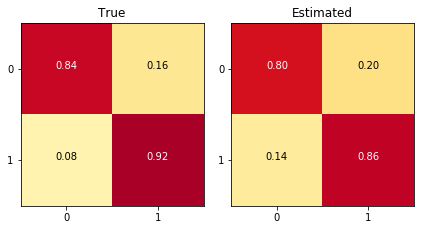

JS divergence: 0.004	Norm Frobenius: 0.048


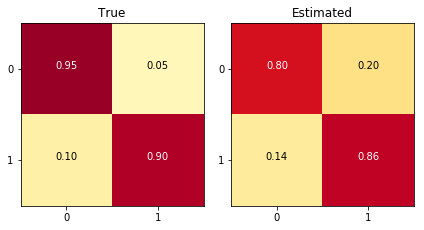

JS divergence: 0.021	Norm Frobenius: 0.110


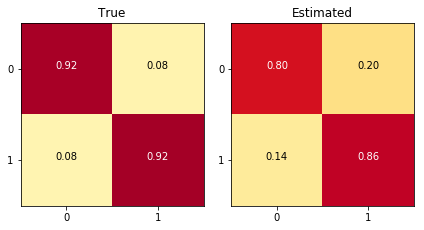

JS divergence: 0.014	Norm Frobenius: 0.095
Calculate confusion matrix on global version


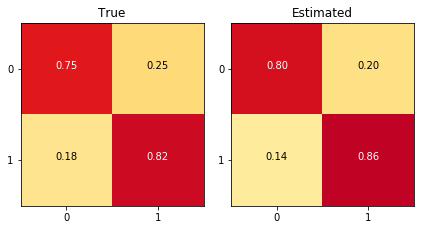

JS divergence: 0.002	Norm Frobenius: 0.040
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.8896,0.8896,0.8896,0.1788,0.0601,0.1329,0.0266,0.0399,0.0019


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7509,0.7509,0.7509


In [25]:
evaluate = Evaluation_metrics(model_mvhard,'keras',X_train.shape[0], text=True)
evaluate.set_T_weights(T_weights)
print("*** Hard-Majority (Train with hardMV) ***")

print("Train")
prob_Yzt = np.tile( mv_conf_onehot, (T,1,1) )
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = mv_conf_onehot)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Dawid and Skene model (Train with D&S) ***
Train
Calculate confusion matrix on repeat version


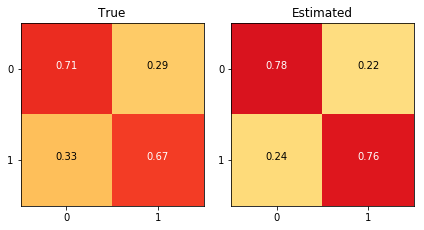

JS divergence: 0.007	Norm Frobenius: 0.087


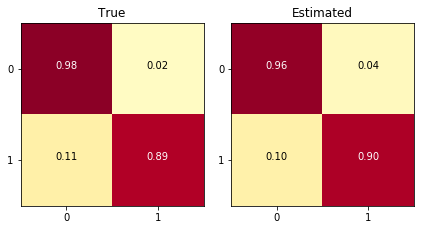

JS divergence: 0.001	Norm Frobenius: 0.014


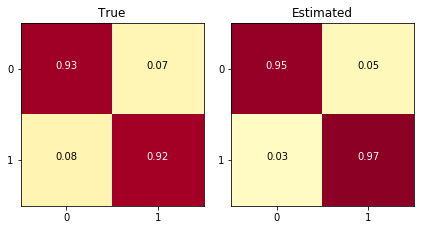

JS divergence: 0.005	Norm Frobenius: 0.037


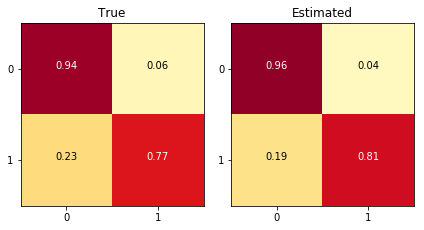

JS divergence: 0.002	Norm Frobenius: 0.033


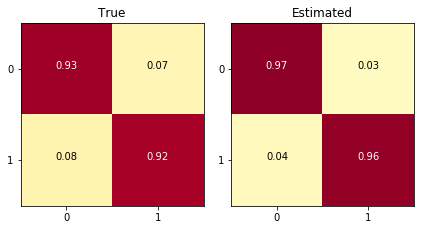

JS divergence: 0.004	Norm Frobenius: 0.035


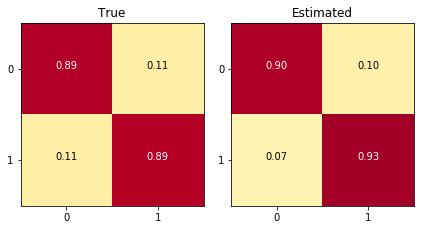

JS divergence: 0.002	Norm Frobenius: 0.029


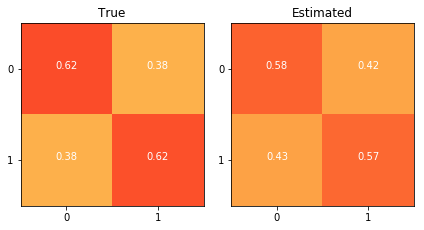

JS divergence: 0.001	Norm Frobenius: 0.044


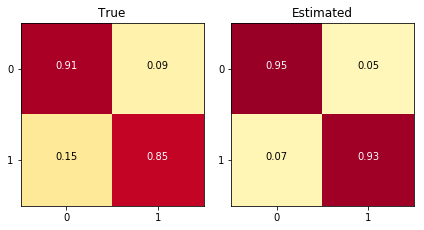

JS divergence: 0.007	Norm Frobenius: 0.060


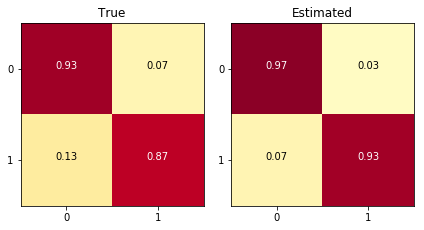

JS divergence: 0.007	Norm Frobenius: 0.049


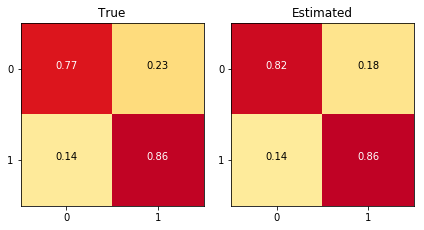

JS divergence: 0.001	Norm Frobenius: 0.033


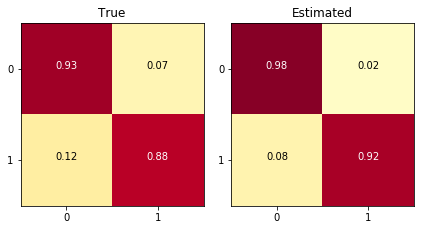

JS divergence: 0.007	Norm Frobenius: 0.044


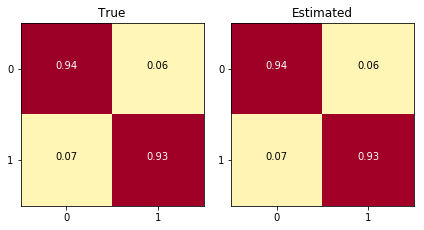

JS divergence: 0.000	Norm Frobenius: 0.004


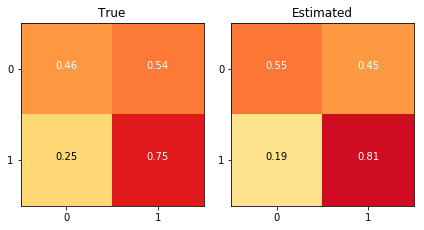

JS divergence: 0.005	Norm Frobenius: 0.074


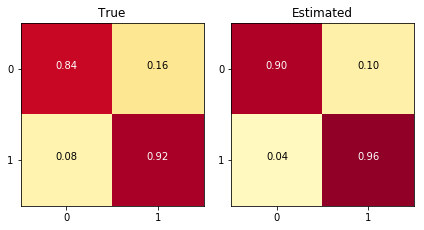

JS divergence: 0.007	Norm Frobenius: 0.055


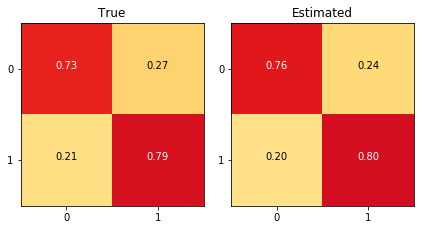

JS divergence: 0.000	Norm Frobenius: 0.021
Calculate confusion matrix on global version


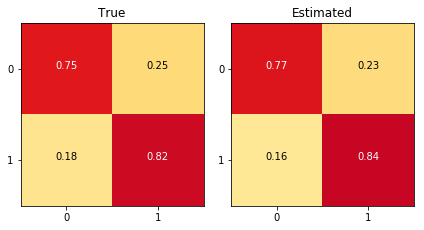

JS divergence: 0.000	Norm Frobenius: 0.017
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS
0,All,0.807,0.807,0.8069,0.0744,0.0205,0.038,0.0047,0.0168,0.0003


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7459,0.7459,0.7459


In [27]:
evaluate = Evaluation_metrics(model_ds,'keras',X_train.shape[0], text=True)
evaluate.set_T_weights(T_weights)
print("*** Dawid and Skene model (Train with D&S) ***")

print("Train")
results1 = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=ds_conf,conf_true=confe_matrix_R,
                                     conf_true_G =confe_matrix_G, conf_pred_G = ds_conf.mean(axis=0))

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Raykar model multiples runs***
Train
Calculate confusion matrix on repeat version


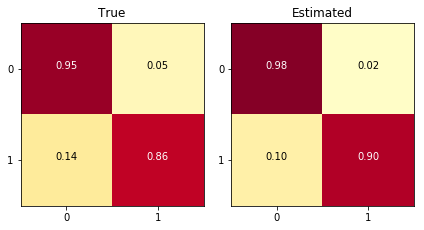

JS divergence: 0.005	Norm Frobenius: 0.036


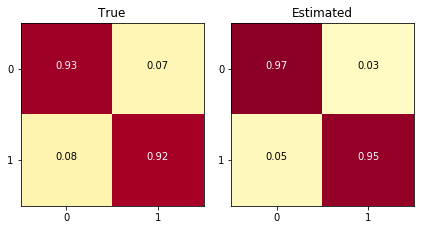

JS divergence: 0.004	Norm Frobenius: 0.035


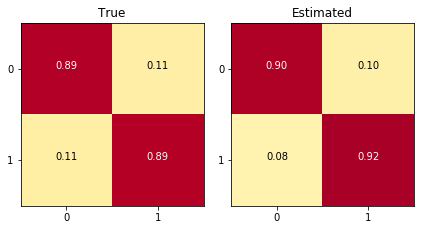

JS divergence: 0.001	Norm Frobenius: 0.022


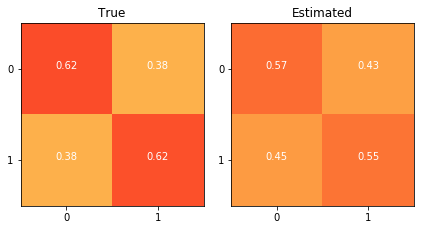

JS divergence: 0.003	Norm Frobenius: 0.065


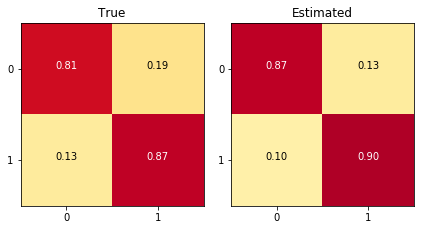

JS divergence: 0.003	Norm Frobenius: 0.045


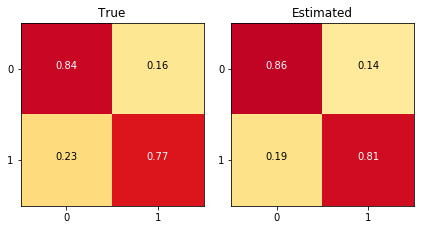

JS divergence: 0.001	Norm Frobenius: 0.032


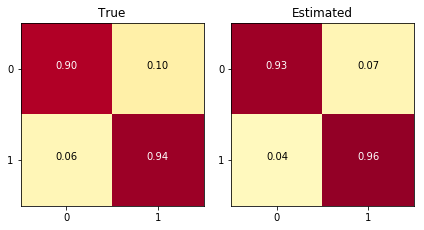

JS divergence: 0.002	Norm Frobenius: 0.029


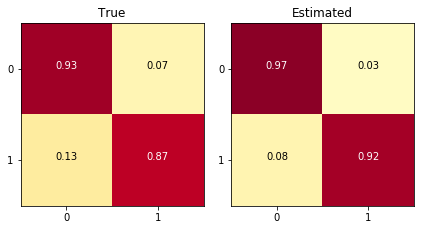

JS divergence: 0.006	Norm Frobenius: 0.046


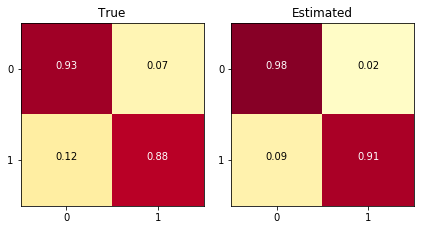

JS divergence: 0.007	Norm Frobenius: 0.040


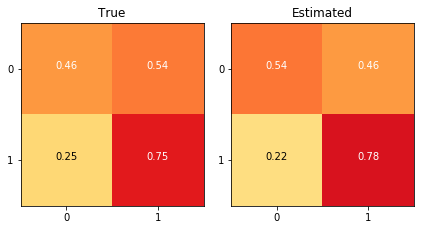

JS divergence: 0.003	Norm Frobenius: 0.063


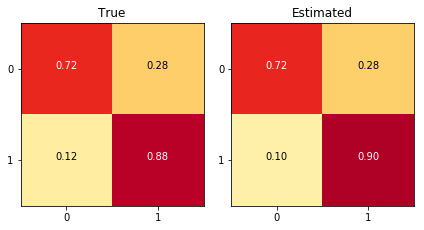

JS divergence: 0.000	Norm Frobenius: 0.012


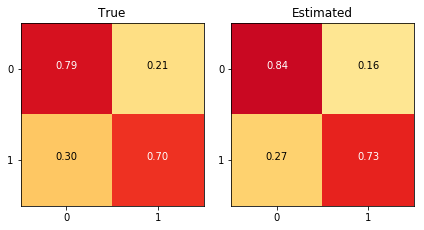

JS divergence: 0.002	Norm Frobenius: 0.040


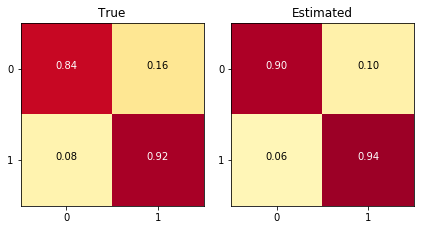

JS divergence: 0.004	Norm Frobenius: 0.048


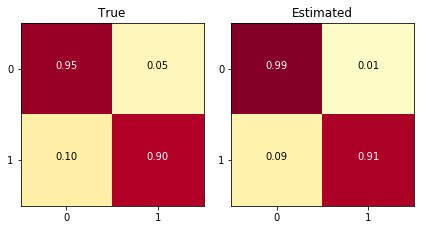

JS divergence: 0.005	Norm Frobenius: 0.028


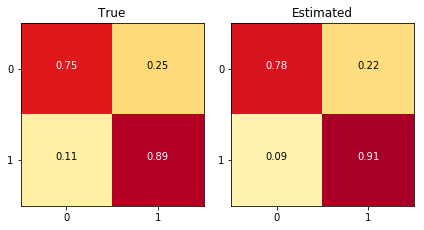

JS divergence: 0.001	Norm Frobenius: 0.027
Calculate confusion matrix on global version


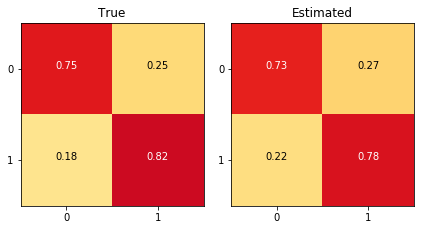

JS divergence: 0.001	Norm Frobenius: 0.033
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.8522,0.8522,0.8522,0.0905,0.0284,0.0356,0.0038,0.0335,0.0012,0.097,0.0857


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.7928,0.7928,0.7369,0.7789,0.7789,0.7511


Test
A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7442,0.7442,0.7435


In [31]:
evaluate = Evaluation_metrics(raykarMC,'raykar', text=True)
print("*** Raykar model multiples runs***")

print("Train")
prob_Yzt = raykarMC.get_confusionM()
prob_Yxt = raykarMC.get_predictions_annot(X_train,data=Z_train_p)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt,conf_true_G =confe_matrix_G, conf_pred_G = prob_Yzt.mean(axis=0))

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
results2 = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred)

*** Ours Global multiples runs***
Train
Calculate confusion matrix on repeat version


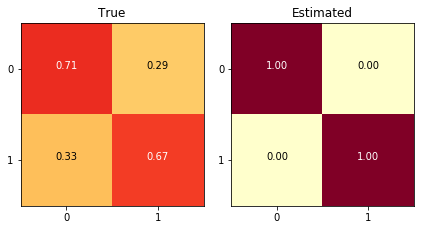

JS divergence: 0.171	Norm Frobenius: 0.313
Groups probabilities:  [1. 0. 0.]


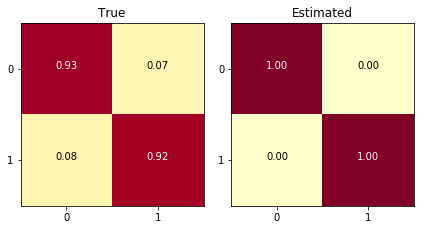

JS divergence: 0.033	Norm Frobenius: 0.072
Groups probabilities:  [1. 0. 0.]


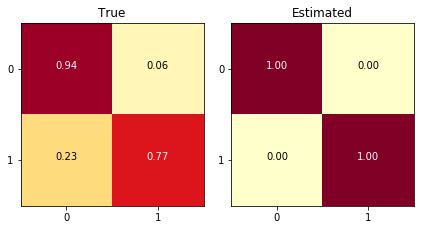

JS divergence: 0.073	Norm Frobenius: 0.166
Groups probabilities:  [1. 0. 0.]


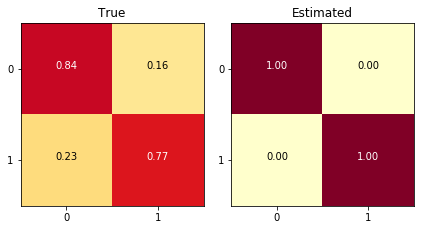

JS divergence: 0.101	Norm Frobenius: 0.197
Groups probabilities:  [1. 0. 0.]


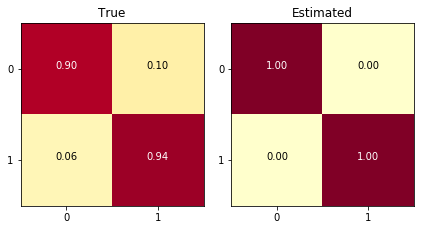

JS divergence: 0.038	Norm Frobenius: 0.082
Groups probabilities:  [1. 0. 0.]


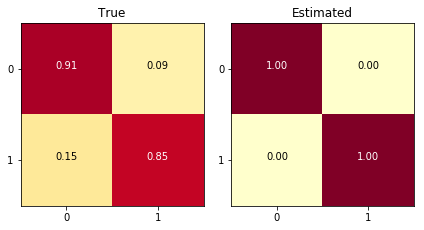

JS divergence: 0.057	Norm Frobenius: 0.120
Groups probabilities:  [1. 0. 0.]


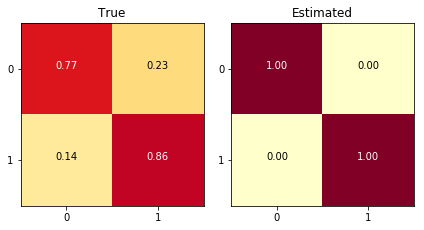

JS divergence: 0.096	Norm Frobenius: 0.190
Groups probabilities:  [1. 0. 0.]


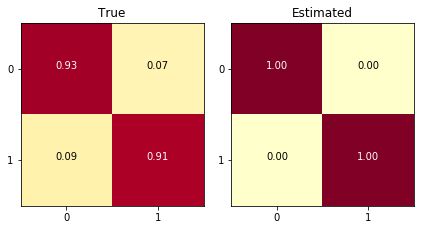

JS divergence: 0.037	Norm Frobenius: 0.080
Groups probabilities:  [1. 0. 0.]


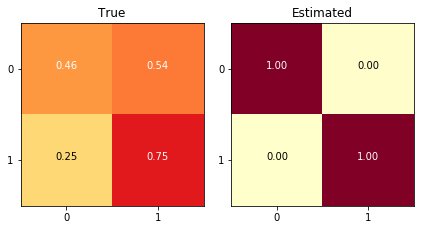

JS divergence: 0.228	Norm Frobenius: 0.416
Groups probabilities:  [0.99 0.   0.01]


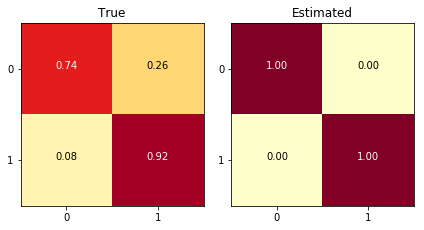

JS divergence: 0.086	Norm Frobenius: 0.188
Groups probabilities:  [1. 0. 0.]


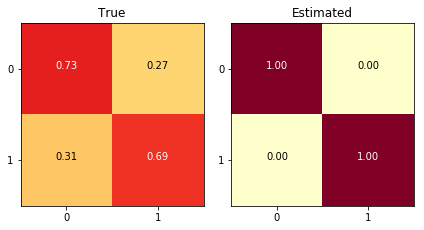

JS divergence: 0.156	Norm Frobenius: 0.286
Groups probabilities:  [1. 0. 0.]


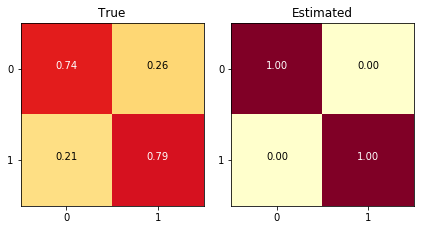

JS divergence: 0.122	Norm Frobenius: 0.232
Groups probabilities:  [1. 0. 0.]


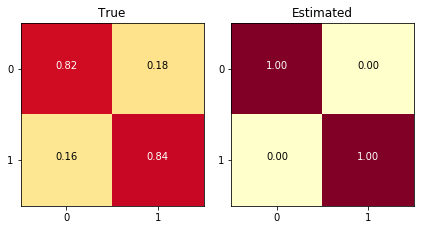

JS divergence: 0.088	Norm Frobenius: 0.172
Groups probabilities:  [1. 0. 0.]


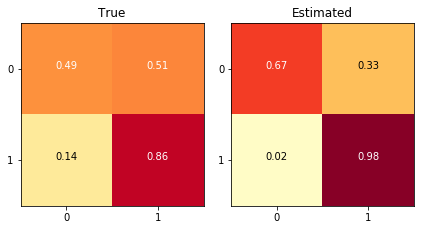

JS divergence: 0.033	Norm Frobenius: 0.154
Groups probabilities:  [0. 0. 1.]


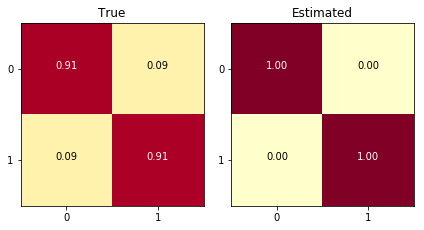

JS divergence: 0.042	Norm Frobenius: 0.088
Groups probabilities:  [1. 0. 0.]
Calculate confusion matrix on global version


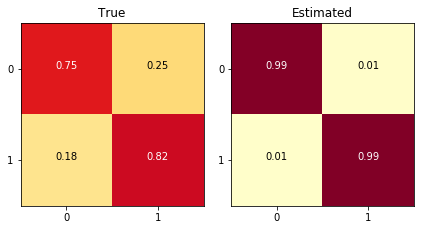

JS divergence: 0.094	Norm Frobenius: 0.205
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.8862,0.8862,0.8861,0.2444,0.1273,0.193,0.0885,0.2053,0.0937,0.1151,0.0976


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.8301,0.8301,0.8154,0.835,0.835,0.8281


Test


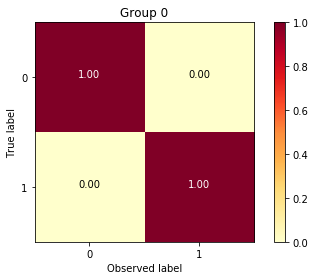

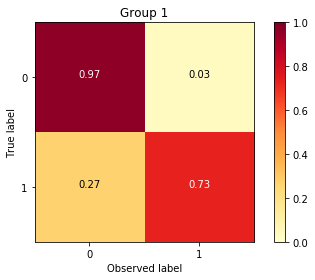

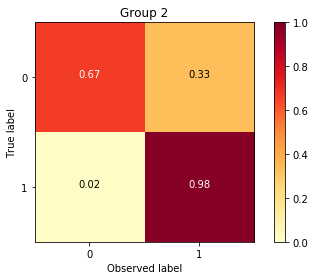

Inertia JS: 0.0978589527949298
Inertia NormF: 0.23619083058379683
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.9611,195,0.0098,0.9987,0.9994,0.9974,0.0002,1,0.0979,0.2362,0.7494,0.7494
1,1,0.0149,3,0.3652,0.8471,0.9157,0.6943,0.1201,0,0.0979,0.2362,0.7257,0.7257
2,2,0.0240,4,0.3632,0.8239,0.8998,0.6479,0.1583,1,0.0979,0.2362,0.7097,0.7097


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7494,0.7494,0.7494


In [37]:
evaluate = Evaluation_metrics(gMixture_Global,'our1', text=True) 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Global.calculate_Yz()
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs***") #lambda = random

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Global,'our1',  text=True) 
aux = gMixture_Global.calculate_extra_components(X_train,y_obs,T=T,calculate_pred_annotator=True,p_z=Z_train_p)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
evaluate.set_Gt(prob_Gt)
print("*** Ours Global multiples runs (Uniform priors) ***") #groups uniform...

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups)

results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Global.get_confusionM()
y_o_groups = gMixture_Global.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

*** Ours Individual-T multiples runs***
Train
Calculate confusion matrix on repeat version


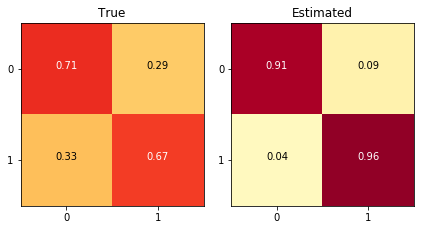

JS divergence: 0.086	Norm Frobenius: 0.256
Groups probabilities:  [0.51 0.15 0.34]


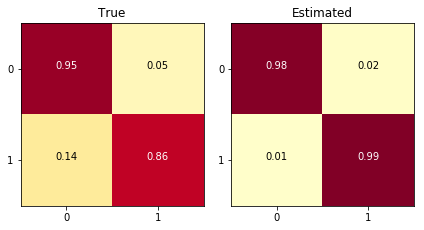

JS divergence: 0.032	Norm Frobenius: 0.096
Groups probabilities:  [0.95 0.03 0.03]


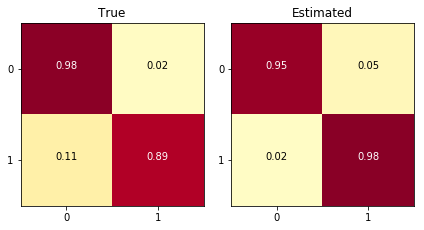

JS divergence: 0.013	Norm Frobenius: 0.062
Groups probabilities:  [0.42 0.09 0.49]


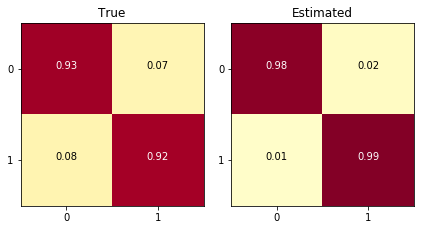

JS divergence: 0.015	Norm Frobenius: 0.057
Groups probabilities:  [0.19 0.04 0.77]


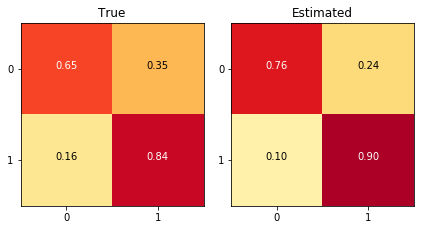

JS divergence: 0.009	Norm Frobenius: 0.093
Groups probabilities:  [0.1  0.42 0.48]


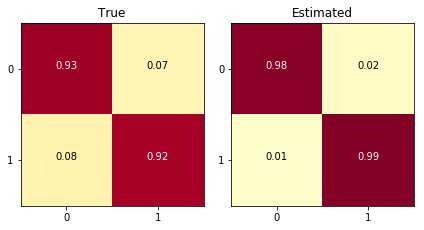

JS divergence: 0.016	Norm Frobenius: 0.058
Groups probabilities:  [0.52 0.04 0.45]


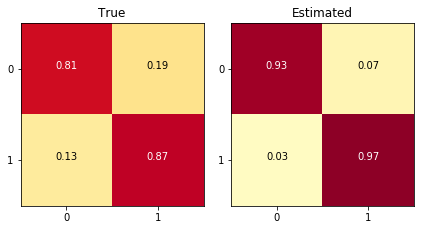

JS divergence: 0.026	Norm Frobenius: 0.111
Groups probabilities:  [0.61 0.12 0.27]


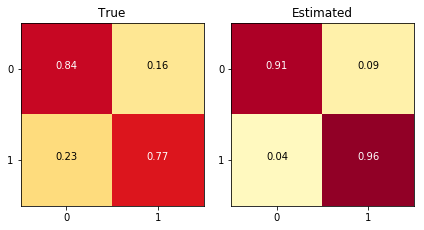

JS divergence: 0.034	Norm Frobenius: 0.143
Groups probabilities:  [0.63 0.17 0.2 ]


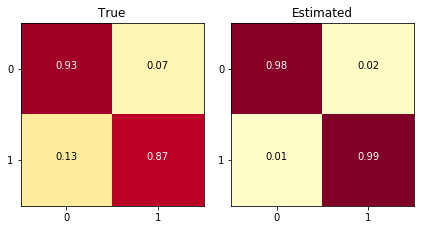

JS divergence: 0.030	Norm Frobenius: 0.091
Groups probabilities:  [0.9  0.03 0.07]


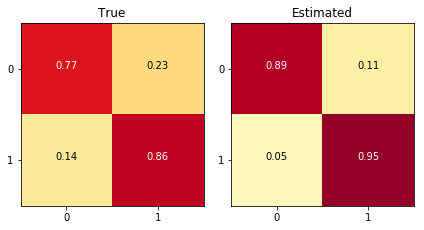

JS divergence: 0.019	Norm Frobenius: 0.107
Groups probabilities:  [0.65 0.2  0.16]


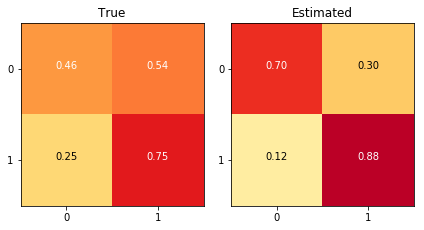

JS divergence: 0.031	Norm Frobenius: 0.191
Groups probabilities:  [0.06 0.53 0.42]


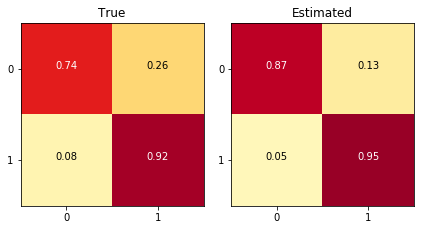

JS divergence: 0.011	Norm Frobenius: 0.094
Groups probabilities:  [0.51 0.22 0.27]


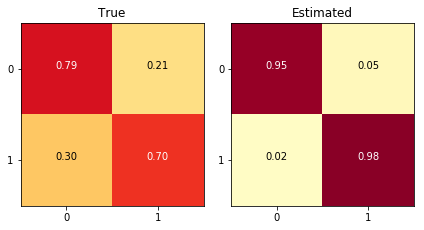

JS divergence: 0.084	Norm Frobenius: 0.231
Groups probabilities:  [0.74 0.09 0.17]


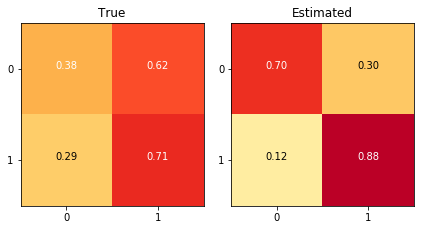

JS divergence: 0.053	Norm Frobenius: 0.254
Groups probabilities:  [0.25 0.53 0.22]


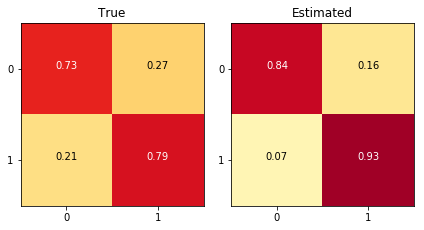

JS divergence: 0.022	Norm Frobenius: 0.127
Groups probabilities:  [0.23 0.28 0.49]
Calculate confusion matrix on global version


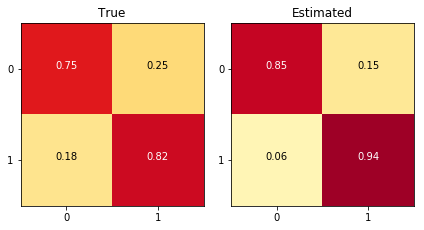

JS divergence: 0.016	Norm Frobenius: 0.103
A result


,,Accuracy,F1 (micro),F1 (macro),(R) NormF mean,(R) JS mean,(R) NormF w,(R) JS w,(G) NormF,(G) JS,RMSE mean,RMSE w
0,All,0.9044,0.9044,0.9044,0.1644,0.0582,0.1086,0.0251,0.1032,0.0163,0.1047,0.0775


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


A result


,ACC imiting Annot mean,F1-mi imiting Annot mean,F1-ma imiting Annot mean,ACC imiting Annot wmean,F1-mi imiting Annot wmean,F1-ma imiting Annot wmean
0,0.8435,0.8435,0.813,0.8313,0.8313,0.8047


Test


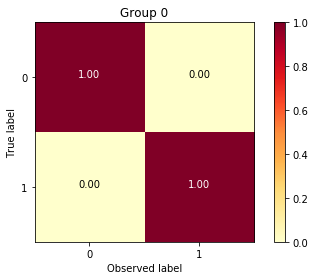

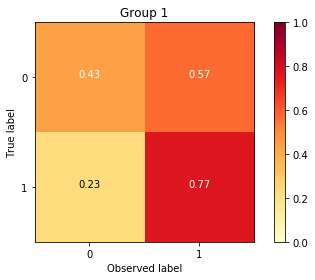

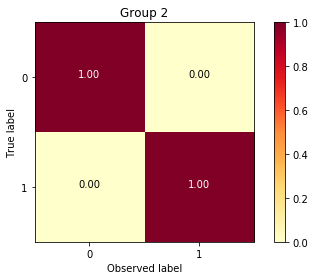

Inertia JS: 0.1627912527947892
Inertia NormF: 0.28975719879549283
A result


,Groups,Prob,T(g),Entropy,Diag mean,Isim (JS),S_raykar,S_bias,C_bias,Iner JS,Iner NormF,Accuracy,F1 (micro)
0,0,0.5025,101,0.0027,0.9997,0.9999,0.9994,0.0000,1,0.1628,0.2898,0.7732,0.7732
1,1,0.2676,54,0.6130,0.5990,0.7519,0.1979,0.1683,1,0.1628,0.2898,0.5221,0.5221
2,2,0.2299,46,0.0108,0.9986,0.9993,0.9971,0.0005,1,0.1628,0.2898,0.7732,0.7732


A result


,,Accuracy,F1 (micro),F1 (macro)
0,All,0.7729,0.7729,0.7728


In [43]:
evaluate = Evaluation_metrics(gMixture_Ind1,'our1', text=True) 
aux = gMixture_Ind1.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind1.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-T multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind1.get_confusionM()
y_o_groups = gMixture_Ind1.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

In [ ]:
evaluate = Evaluation_metrics(gMixture_Ind3,'our1', text=True) 
aux = gMixture_Ind3.calculate_extra_components(X_train, A,calculate_pred_annotator=True,p_z=Z_train_p,p_g=prob_Gt)
predictions_m,prob_Gt,prob_Yzt,prob_Yxt =  aux #to evaluate...
prob_Yz = gMixture_Ind3.calculate_Yz(prob_Gt)
evaluate.set_Gt(prob_Gt)
print("*** Ours Individual-K multiples runs***")

print("Train")
y_o_groups = predictions_m.argmax(axis=-1)
results = evaluate.calculate_metrics(Z=Z_train,Z_pred=Z_train_pred,conf_pred=prob_Yzt,conf_true=confe_matrix_R,
                                     y_o=y_obs,yo_pred=prob_Yxt, y_o_groups=y_o_groups,
                                    conf_true_G =confe_matrix_G, conf_pred_G = prob_Yz)
results = evaluate.calculate_metrics(y_o=y_obs,yo_pred=prob_Yxt)

print("Test")
c_M = gMixture_Ind3.get_confusionM()
y_o_groups = gMixture_Ind3.get_predictions_groups(X_test,data=Z_test_p).argmax(axis=-1) #obtain p(y^o|x,g=m) and then argmax
results = evaluate.calculate_metrics(Z=Z_test,Z_pred=Z_test_pred,conf_pred=c_M, y_o_groups=y_o_groups)

### project confusion matrices

In [54]:
def flatten_conf(m):
    return m.reshape(m.shape[0], np.prod(m.shape[1:]))

to_plot = flatten_conf(confe_matrix_R)

centroids_plot_G = flatten_conf(gMixture_Global.get_confusionM())
centroids_plot_IT = flatten_conf(gMixture_Ind1.get_confusionM())
#centroids_plot_I2 = flatten_conf(gMixture_Ind2.get_confusionM())
centroids_plot_IK = flatten_conf(gMixture_Ind3.get_confusionM())
global_plot = (confe_matrix_G.flatten()).reshape(1,-1)

from sklearn.decomposition import PCA
model = PCA(2)
model.fit(to_plot) 

to_plot = model.transform(to_plot) 
centroids_plot_G = model.transform(centroids_plot_G)
centroids_plot_IT = model.transform(centroids_plot_IT)
#centroids_plot_I2 = model.transform(centroids_plot_I2)
centroids_plot_IK = model.transform(centroids_plot_IK)
global_plot = model.transform(global_plot)

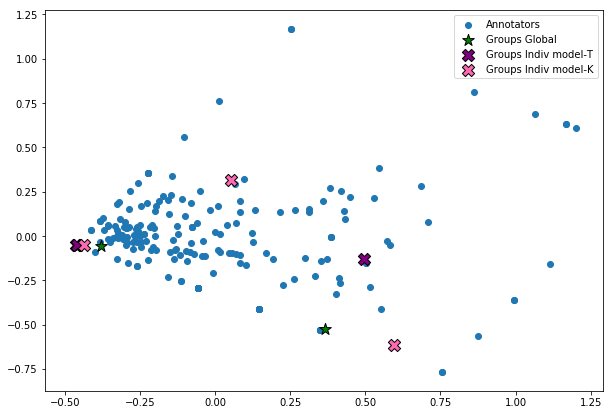

In [34]:
plt.figure(figsize=(10,7))
plt.scatter(to_plot[:,0], to_plot[:,1], label="Annotators")
plt.scatter(centroids_plot_G[:,0], centroids_plot_G[:,1], s=150,marker="*", color='g',label="Groups Global", edgecolor='black')
plt.scatter(centroids_plot_IT[:,0], centroids_plot_IT[:,1],s=150, marker="X", color='purple',label="Groups Indiv model-T", edgecolor='black')
plt.scatter(centroids_plot_IK[:,0], centroids_plot_IK[:,1], s=150, marker="X", color='hotpink',label="Groups Indiv model-K", edgecolor='black')
#plt.scatter(global_plot[:,0], global_plot[:,1],label="Global")

plt.legend()
plt.show()#nuevo